In [13]:
import sys
import os
import json
import numpy as np

sys.path.append("../../..")

import matplotlib.pyplot as plt

DATA_DIR = "../../../data"
datasets = os.listdir(DATA_DIR)
datasets

['dx.doi.org_10.4121_uuid_3537c19d-6c64-4b1d-815d-915ab0e479da',
 'dx.doi.org_10.4121_uuid_679b11cf-47cd-459e-a6de-9ca614e25985',
 'dx.doi.org_10.4121_uuid_c2c3b154-ab26-4b31-a0e8-8f2350ddac11',
 'dx.doi.org_10.4121_uuid_3d5ae0ce-198c-4b5c-b0f9-60d3035d07bf',
 'doi.org_10.4121_uuid_d06aff4b-79f0-45e6-8ec8-e19730c248f1',
 'dx.doi.org_10.4121_uuid_86977bac-f874-49cf-8337-80f26bf5d2ef',
 'dx.doi.org_10.4121_uuid_3cfa2260-f5c5-44be-afe1-b70d35288d6d',
 'dx.doi.org_10.4121_uuid_e30ba0c8-0039-4835-a493-6e3aa2301d3f',
 'dx.doi.org_10.4121_uuid_9b99a146-51b5-48df-aa70-288a76c82ec4',
 'dx.doi.org_10.4121_uuid_2b02709f-9a84-4538-a76a-eb002eacf8d1',
 'dx.doi.org_10.4121_uuid_d9769f3d-0ab0-4fb8-803b-0d1120ffcf54',
 'dx.doi.org_10.4121_uuid_c3f3ba2d-e81e-4274-87c7-882fa1dbab0d',
 'dx.doi.org_10.4121_uuid_01345ac4-7d1d-426e-92b8-24933a079412',
 'dx.doi.org_10.4121_uuid_500573e6-accc-4b0c-9576-aa5468b10cee']

In [14]:
def filter_files(fs: list[str]) -> list[str]:
    return list(filter(lambda f: f.endswith('.csv') or f.endswith('.xes'), fs))

files = {d: filter_files(os.listdir(f"{DATA_DIR}/{d}")) for d in datasets}
files

{'dx.doi.org_10.4121_uuid_3537c19d-6c64-4b1d-815d-915ab0e479da': ['BPI_Challenge_2013_open_problems.xes'],
 'dx.doi.org_10.4121_uuid_679b11cf-47cd-459e-a6de-9ca614e25985': ['BPIC15_4.xes'],
 'dx.doi.org_10.4121_uuid_c2c3b154-ab26-4b31-a0e8-8f2350ddac11': ['BPI_Challenge_2013_closed_problems.xes'],
 'dx.doi.org_10.4121_uuid_3d5ae0ce-198c-4b5c-b0f9-60d3035d07bf': ['Detail_Interaction.csv'],
 'doi.org_10.4121_uuid_d06aff4b-79f0-45e6-8ec8-e19730c248f1': ['BPI_Challenge_2019.xes'],
 'dx.doi.org_10.4121_uuid_86977bac-f874-49cf-8337-80f26bf5d2ef': ['Detail_Incident_Activity.csv'],
 'dx.doi.org_10.4121_uuid_3cfa2260-f5c5-44be-afe1-b70d35288d6d': ['Detail_Incident.csv'],
 'dx.doi.org_10.4121_uuid_e30ba0c8-0039-4835-a493-6e3aa2301d3f': ['BPI2016_Complaints.csv'],
 'dx.doi.org_10.4121_uuid_9b99a146-51b5-48df-aa70-288a76c82ec4': ['BPI2016_Clicks_NOT_Logged_In.csv'],
 'dx.doi.org_10.4121_uuid_2b02709f-9a84-4538-a76a-eb002eacf8d1': ['BPI2016_Questions.csv'],
 'dx.doi.org_10.4121_uuid_d9769f3d-0ab0-4

In [15]:
def make_path(doi: str):
    for f in files[doi]:
        yield f"{DATA_DIR}/{doi}/{f}"

def get_summary(path: str):
    return json.load(open(path))

summaries = {}

for doi in datasets:
    for path in make_path(doi):
        summary_path = '/'.join(path.split('/')[:-1] + ["summary.json"])
        s = get_summary(summary_path)
        summaries[path] = s

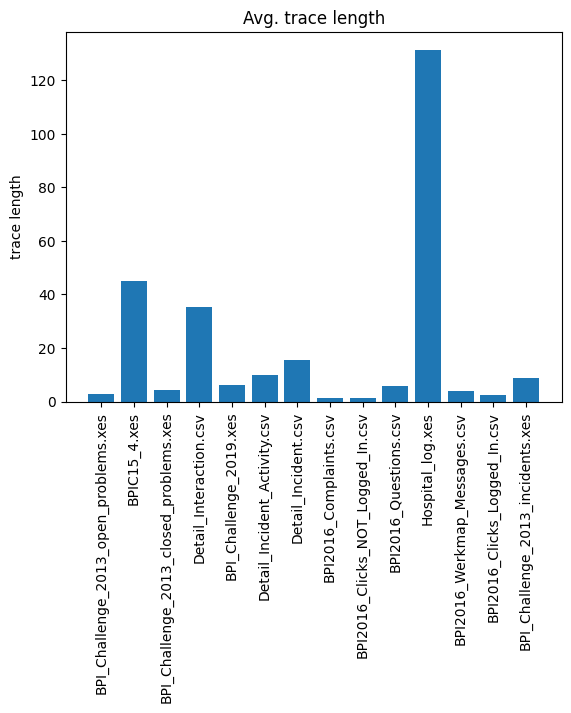

In [16]:
fig, ax = plt.subplots()

sets, avg_trace_lengths = zip(*[(k.split('/')[-1], v["avg_trace_len"]) for k, v in summaries.items()])
bar_labels = sets

ax.bar(sets, avg_trace_lengths, label=bar_labels)
ax.set_ylabel('trace length')
ax.set_title('Avg. trace length')

plt.xticks(rotation=90)
plt.show()

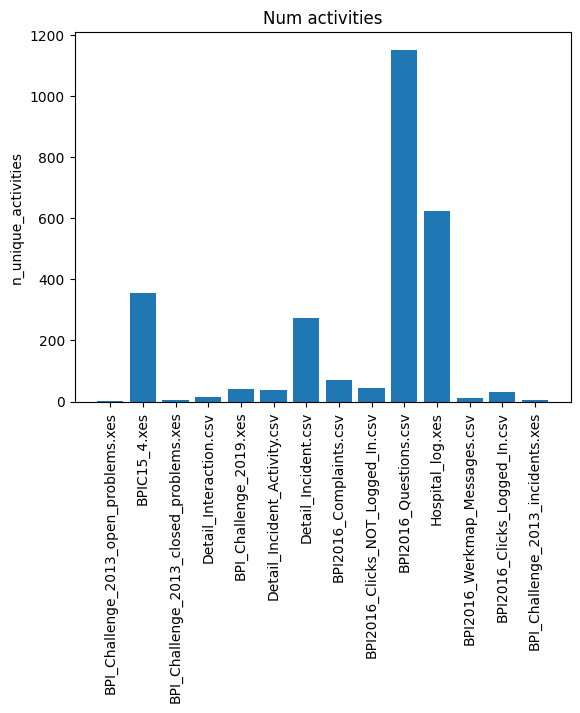

In [17]:
fig, ax = plt.subplots()

sets, n_activities = zip(*[(k.split('/')[-1], v["n_unique_activities"]) for k, v in summaries.items()])
bar_labels = sets

ax.bar(sets, n_activities, label=bar_labels)
ax.set_ylabel('n_unique_activities')
ax.set_title('Num activities')

plt.xticks(rotation=90)
plt.show()

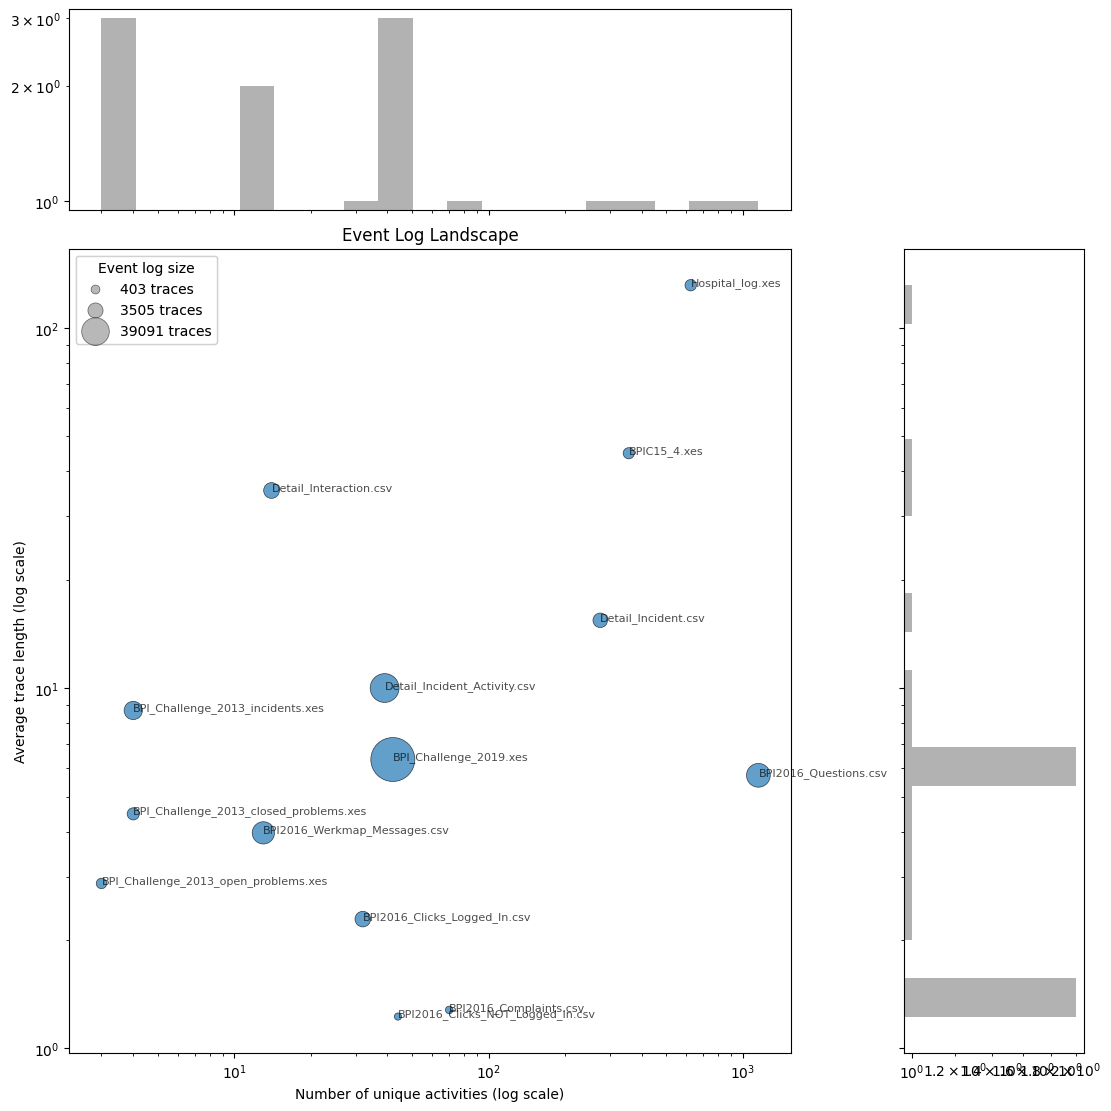

In [18]:
def scatter_hist_datasets(summaries, log_space: bool = False, size_scale: float = 0.3):
    """
    Scatter + histogram plot for event log summary stats.

    Args:
        summaries: dict of {name: {"n_unique_activities": int, "avg_trace_len": float, "n_traces": int, ...}}
        log_space: whether to use log scale on both axes
        size_scale: multiplicative scaling for bubble area
    """

    names = [k.split('/')[-1] for k in summaries.keys()]
    n_activities = np.array([v["n_unique_activities"] for v in summaries.values()])
    avg_trace_len = np.array([v["avg_trace_len"] for v in summaries.values()])
    n_traces = np.array([v.get("n_traces", 1) for v in summaries.values()])  # fallback if missing

    fig, axs = plt.subplot_mosaic(
        [['histx', '.'],
         ['scatter', 'histy']],
        figsize=(11, 11),
        width_ratios=(4, 1),
        height_ratios=(1, 4),
        layout='constrained'
    )

    ax_scatter = axs['scatter']
    ax_histx = axs['histx']
    ax_histy = axs['histy']

    # Bubble sizes: scale so they don't overwhelm
    sizes = np.sqrt(n_traces) * size_scale

    scatter = ax_scatter.scatter(
        n_activities, avg_trace_len,
        s=sizes, alpha=0.7, edgecolors='black', linewidths=0.5
    )

    # Annotate points
    for i, name in enumerate(names):
        ax_scatter.annotate(name, (n_activities[i], avg_trace_len[i]), fontsize=8, alpha=0.7)

    # Log scaling if requested
    if log_space:
        for ax in (ax_scatter, ax_histx, ax_histy):
            ax.set_xscale('log')
            ax.set_yscale('log')

    ax_scatter.set_xlabel("Number of unique activities" + (" (log scale)" if log_space else ""))
    ax_scatter.set_ylabel("Average trace length" + (" (log scale)" if log_space else ""))
    ax_scatter.set_title("Event Log Landscape")

    # Bins for histograms
    if log_space:
        bins_x = np.geomspace(n_activities.min(), n_activities.max(), 20)
        bins_y = np.geomspace(avg_trace_len.min(), avg_trace_len.max(), 20)
    else:
        bins_x = np.linspace(n_activities.min(), n_activities.max(), 20)
        bins_y = np.linspace(avg_trace_len.min(), avg_trace_len.max(), 20)

    # Histograms
    ax_histx.hist(n_activities, bins=bins_x, color="gray", alpha=0.6)
    ax_histy.hist(avg_trace_len, bins=bins_y, orientation='horizontal', color="gray", alpha=0.6)

    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # Legend for bubble size
    import matplotlib.lines as mlines
    from matplotlib.legend import Legend

    # pick a few representative sizes for legend
    legend_sizes = np.percentile(n_traces, [10, 50, 90])
    handles = [
        plt.scatter([], [], s=np.sqrt(s)*size_scale, color='gray', alpha=0.5,
                    edgecolors='black', linewidths=0.5, label=f"{int(s)} traces")
        for s in legend_sizes
    ]
    legend = ax_scatter.legend(
        handles=handles,
        title="Event log size",
        loc='upper left',
        frameon=True
    )
    ax_scatter.add_artist(legend)

    plt.show()

scatter_hist_datasets(summaries, True, 2.0)